In [1]:
import os
import re
import gc

import dlib
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import distance

from face_swap import warp_image_2d, warp_image_3d, mask_from_points, \
                      apply_mask, correct_colours, transformation_from_points

#### TO DO:  
 - download images and make a mix in one request  
 - shaded answer  
 - preprocess_img is a bottleneck -- faces comparison must be parallel!  
 - make possible to select people on selfies  
 - exceptions when no faces found / no faces selected but at least one found on both photos  
 - optimize docker  
 - add log file  

In [2]:
path = "./data"

In [3]:
def show_img(img, figsize=(7, 14)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()
    
def crop_face(img, bboxs, offset=10):
    imgs = []
    for bbox in bboxs:
        x = bbox[0] 
        y = bbox[1]
        w = bbox[2] - x
        h = bbox[3] - y

        x = max(x - offset//2, 0)
        y = max(y - offset//2, 0)
        w = min(img.shape[0], w + offset)
        h = min(img.shape[1], h + offset)
        imgs.append(img[y:y+h, x:x+w])
    return imgs

In [12]:
def open_img(name, biggest=400):
    img = cv2.imread(os.path.join(path, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scale = biggest / max(img.shape[:-1]) 
    img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)), Image.LANCZOS)
    return img

def face_detection(img):
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detector = dlib.get_frontal_face_detector()
    faces = detector(img, 1)
    bboxs = []

    for face in faces:
        bboxs.append((face.left(), face.top(), face.right(), face.bottom()))
    
    return bboxs

def face_points_detection(img, bbox):
    # Get the landmarks/parts for the face in box d.
    shape = predictor(img, bbox)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    coords = [(shape.part(i).x, shape.part(i).y) for i in range(68)]

    # return the list of (x, y)-coordinates
    return coords

def select_faces(im, bbox, r=10):
    points = face_points_detection(im, dlib.rectangle(*bbox))
    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)
    
    x, y = max(0, left-r), max(0, top-r)
    w, h = min(right+r, im_h)-x, min(bottom+r, im_w)-y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y+h, x:x+w]

def calc_dist(img0, img1):
    return distance.euclidean(img0, img1)

def preprocess_img(max_dst_boxes=25, embeddings_max_iters=20, *args):
    my_bboxs = np.array(face_detection(ME))
    
    # args is points on the faces to be swapped (selfies / friends photos)
    if args:
        to_keep = []
        for arg in args:
            for j, bbox in enumerate(my_bboxs):
                if (bbox[0] <= arg[0] <= bbox[2]) and \
                   (bbox[1] <= arg[1] <= bbox[3]):
                        to_keep.append(j)
        my_bboxs = my_bboxs[to_keep]
            
    bboxs = np.array(face_detection(CROWD))
    if len(bboxs) == 0 or len(my_bboxs) == 0:
        return None
    
    random_sample_bboxs = np.random.choice(list(range(len(bboxs))), size=min(len(bboxs), max_dst_boxes))
    random_sample_my_bboxs = np.random.choice(list(range(len(my_bboxs))), size=min(len(my_bboxs), max_dst_boxes))
    
    if len(random_sample_bboxs) < len(bboxs):
        bboxs = bboxs[random_sample]
        
    if len(random_sample_my_bboxs) < len(my_bboxs):
        my_bboxs = my_bboxs[random_sample]

    out, ignore_list = [], []
    for i in range(len(my_bboxs)):
        src_face_descriptor = facerec.compute_face_descriptor(ME, 
                              sp(ME, dlib.rectangle(*my_bboxs[i])), embeddings_max_iters)
        dsts = np.full(len(bboxs), np.inf)
        for j, bbox in enumerate(bboxs):
            if j in ignore_list:
                continue
            face_descriptor = facerec.compute_face_descriptor(CROWD,
                              sp(CROWD, dlib.rectangle(*bbox)), embeddings_max_iters)
            dsts[j] = calc_dist(src_face_descriptor, face_descriptor)
        clst = np.random.choice(np.argsort(dsts)[:2])
        ignore_list.append(clst)
        out.append((select_faces(CROWD, bboxs[clst]), select_faces(ME, my_bboxs[i])))
    return out

def insert_face():
    
    result = preprocess_img()
    if result is None:
        return None
    
    result_bboxs = []
    for faces in result:
        dst_points, dst_shape, dst_face = faces[0]
        src_points, src_shape, src_face = faces[1]

        warp_2d = False
        correct_color = True
        max_points = 58

        w, h = dst_face.shape[:2]

        ### Warp Image
        if not warp_2d:
            ## 3d warp
            warped_src_face = warp_image_3d(src_face, src_points[:max_points], dst_points[:max_points], (w, h))
        else:
            ## 2d warp
            src_mask = mask_from_points(src_face.shape[:2], src_points, radius=2)
            src_face = apply_mask(src_face, src_mask)
            # Correct Color for 2d warp
            if correct_color:
                warped_dst_img = warp_image_3d(dst_face, dst_points[:max_points], 
                                               src_points[:max_points], src_face.shape[:2])
                src_face = correct_colours(warped_dst_img, src_face, src_points)
            # Warp
            warped_src_face = warp_image_2d(src_face, transformation_from_points(dst_points, src_points), (w, h, 3))

        ## Mask for blending
        mask = mask_from_points((w, h), dst_points, radius=2)
        mask_src = np.mean(warped_src_face, axis=2) > 0
        mask = np.asarray(mask*mask_src, dtype=np.uint8)

        ## Correct color
        if not warp_2d and correct_color:
            warped_src_face = apply_mask(warped_src_face, mask)
            dst_face_masked = apply_mask(dst_face, mask)
            warped_src_face = correct_colours(dst_face_masked, warped_src_face, dst_points)

        ##Poisson Blending
        r = cv2.boundingRect(mask)
        center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
        output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

        x, y, w, h = dst_shape
        result_bboxs.append(dst_shape)
        
        #dst_img_cp = CROWD.copy()
        CROWD[y:y+h, x:x+w] = output
        #output = dst_img_cp
        

    output_labeled = CROWD.copy()
    for bbox in result_bboxs:
        x, y, w, h = bbox
        cv2.rectangle(output_labeled, (x, y), (x+w, y+h), (255,0,0), 2)
    
    return output_labeled

In [5]:
# face landmarks
predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

# dlib facerecognition
sp = dlib.shape_predictor("./models/shape_predictor_5_face_landmarks.dat")
facerec = dlib.face_recognition_model_v1("./models/dlib_face_recognition_resnet_model_v1.dat")

In [8]:
%%time

#ME = open_img("you_2.jpg", biggest=400)
#ME = open_img("you_main.jpg", biggest=400)
ME = open_img("trump_3.png", biggest=1200)

CROWD = open_img("playboy.png", biggest=1200)
#CROWD = open_img("trump.png", biggest=1200)
#CROWD = open_img("kim.jpg", biggest=1200)

CPU times: user 148 ms, sys: 16 ms, total: 164 ms
Wall time: 94.4 ms


python main.py --src imgs/test6.jpg --dst imgs/test7.jpg --out results/output6_7_2d.jpg --correct_color --warp_2d

In [9]:
%%time

output_labeled = insert_face()

CPU times: user 5.04 s, sys: 1.07 s, total: 6.12 s
Wall time: 5.72 s


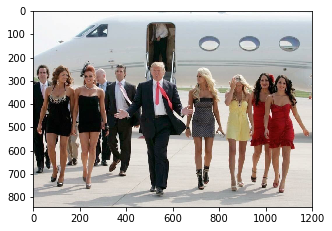

In [19]:
show_img(ME, figsize=(5, 10))

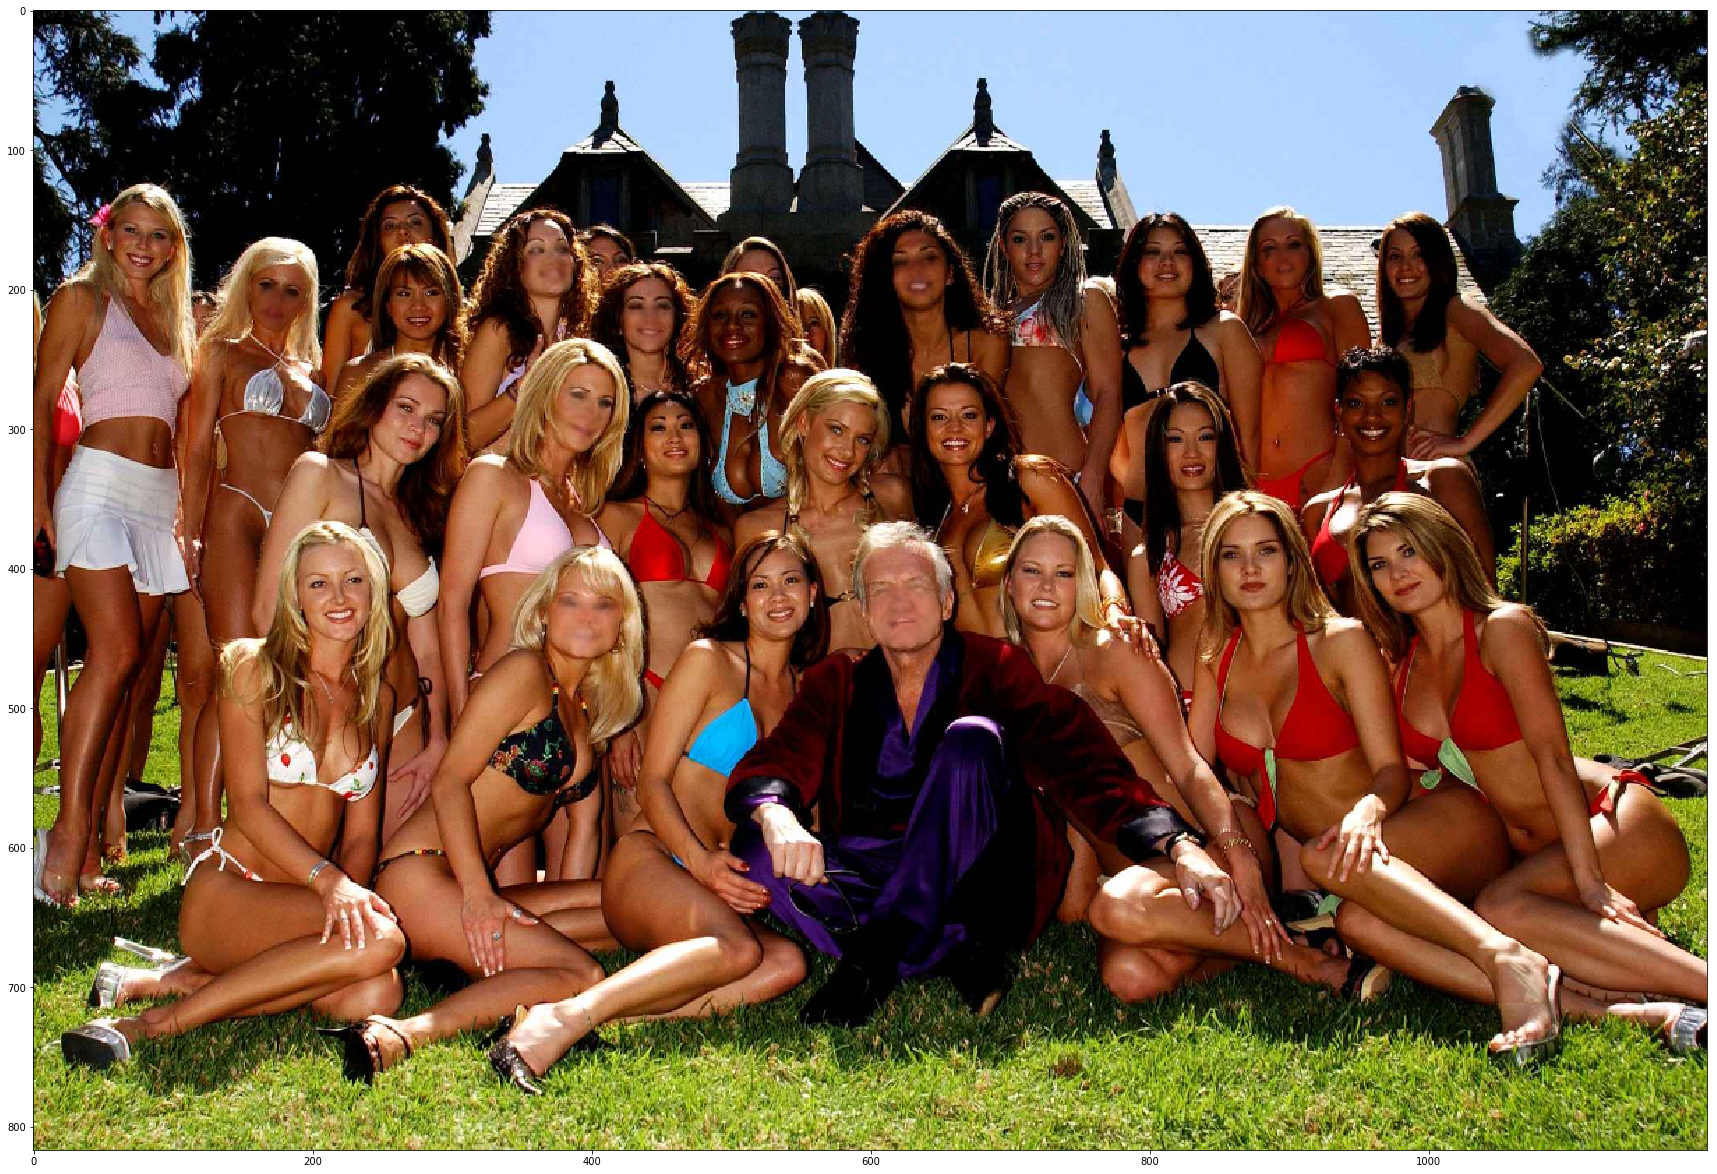

In [10]:
show_img(CROWD, figsize=(30, 60))

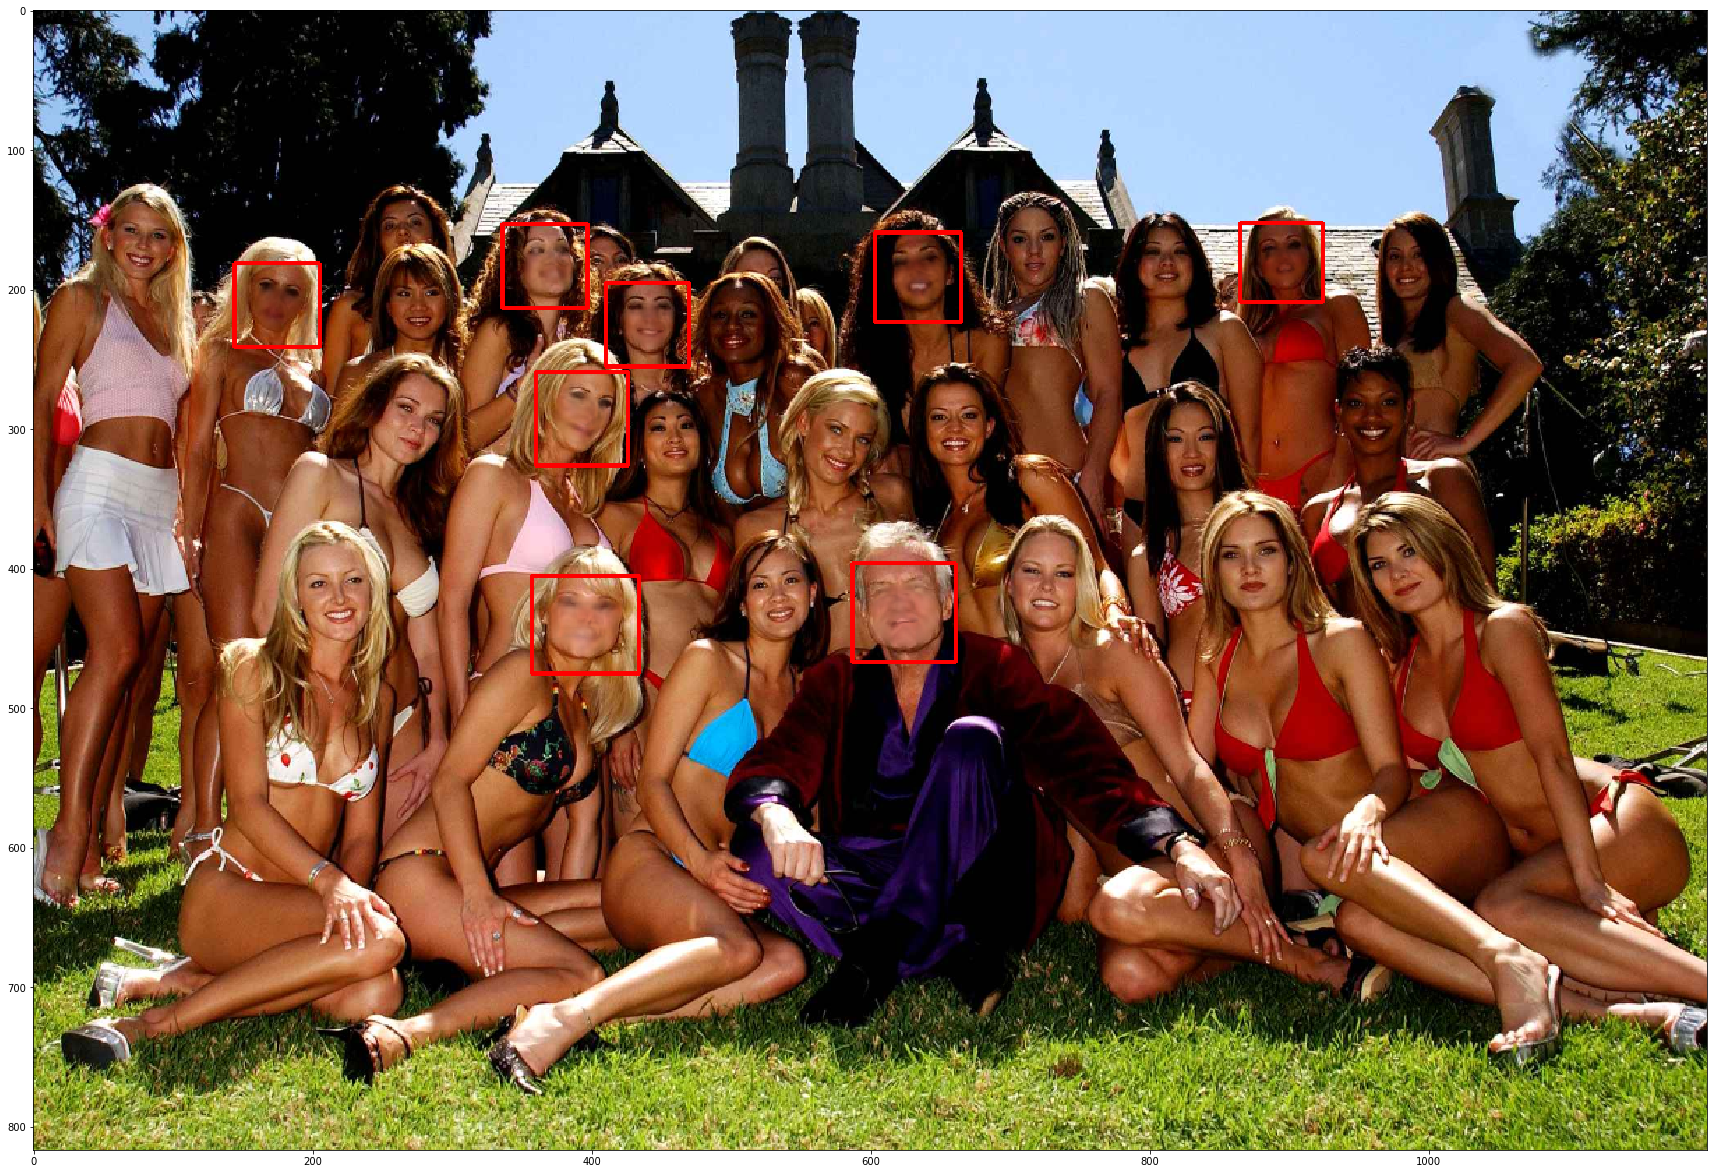

In [11]:
show_img(output_labeled, figsize=(30, 60))

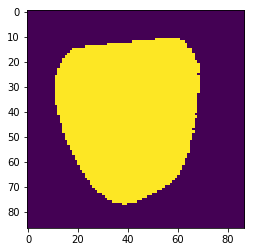

In [75]:
plt.imshow(mask)

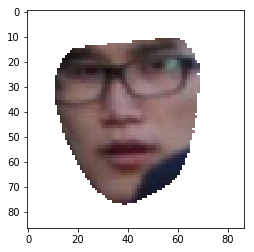

In [76]:
plt.imshow(np.concatenate([dst_face, mask[:, :, np.newaxis]], axis=2))

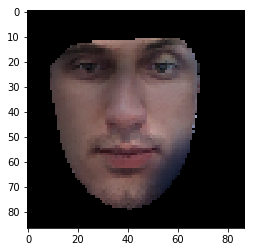

In [77]:
plt.imshow(warped_src_face)

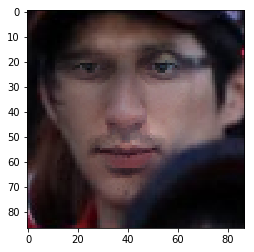

In [78]:
plt.imshow(new_output)

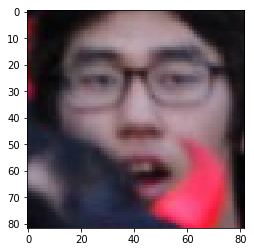

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()

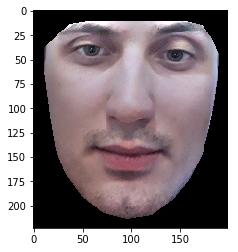

In [23]:
plt.imshow(src_face)

In [35]:
points = face_detection(me)[0]
me_cropped = me[points[1]:points[3], points[0]:points[2]]

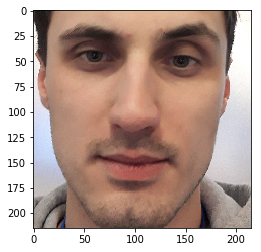

In [79]:
plt.imshow(me_cropped)
plt.show()

In [37]:
cv2.imwrite("./data/me_cropped.jpg", me_cropped)

True

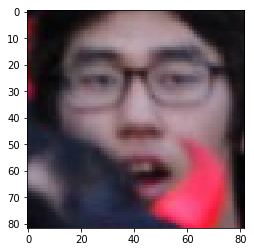

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()

### Facenet approach: